# Effect of cancelling a process zero
The following exercise is taken from Åström & Wittenmark (problem 5.3)

Consider the system with pulse-transfer function 
$$ H(z) = \frac{z+0.7}{z^2 - 1.8z + 0.81}.$$
Use polynomial design to determine a controller such that the closed-loop system has the characteristic polynomial $$ A_c = z^2 -1.5z + 0.7. $$
Let the observer polynomial have as low order as possible, and place all observer poles in the origin (dead-beat observer). Consider the following two cases 

(a) The process zero is cancelled

(b) The process zero is not cancelled.

Simulate the two cases and discuss the differences between the two controllers. Which one should be preferred?

(c) Design an incremental controller for the system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control
import sympy as sy

## Checking the poles
Before solving the problem, let's look at the location of the poles of the plant and the desired closed-loop system.

(array([0.90000002, 0.89999998]), array([-0.7]))

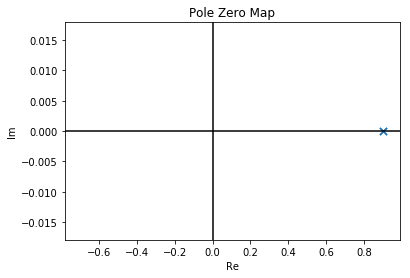

In [2]:
H = control.tf([1, 0.7], [1, -1.8, 0.81], 1)
control.pzmap(H)

In [3]:
z = sy.symbols("z", real=False)
Ac = sy.Poly(z**2 - 1.5*z + 0.7,z)
sy.roots(Ac)

{0.75 + 0.370809924354783*I: 1, 0.75 - 0.370809924354783*I: 1}

So, the plant has a double pole in $z=0.9$, and the desired closed-loop system has complex-conjugated poles in $z=0.75 \pm i0.37$.

## (a)
### The feedback controller $F_b(z)$
The plant has numerator polynomial $B(z) = z+0.7$ and denominator polynomial $A(z) = z^2 - 1.8z + 0.81$. With the feedback controller $$F_b(z) = \frac{S(z)}{R(z)}$$ and feedforward $$F_f(z) = \frac{T(z)}{R(z)}$$ the closed-loop pulse-transfer function from the command signal to the output becomes 
$$ H_{c}(z) = \frac{\frac{T(z)}{R(z)} \frac{B(z)}{A(z)}}{1 + \frac{B(z)}{A(z)}\frac{S(z)}{R(z)}} = \frac{T(z)(z+0.7)}{A(z)R(z) + S(z)(z+0.7)}.$$
To cancel the process zero, $z+0.7$ should be a factor of $R(z)$. Write $R(z)= \bar{R}(z)(z+0.7)$ to obtain the Diophantine equation
$$ A(z)\bar{R}(z) + S(z) = A_c(z)A_o(z).$$


Let's try to find a minimum-order controller that solves the Diophantine equation. The degree of the left hand side (and hence also of the right-hand side) is 
$$ \deg (A\bar{R} + S) = \deg A + \deg \bar{R} = 2 + \deg\bar{R}.$$
The number of equations obtained when setting the coefficients of the left- and right-hand side equal is the same as the degree of the polynomials on each side (taking into account that the leading coefficient is 1, by convention). 

The feedback controller can be written
$$ F_b(z) = \frac{S(z)}{R(z)} = \frac{s_0z^n + s_1z^{n-1} + \cdots + s_n}{(z+0.7)(z^{n-1} + r_1z^{n-2} + \cdots + r_{n-1}}, $$
which has $(n-1) + (n+1) = 2n$ unknown parameters, where $n = \deg\bar{R} + 1$.
So to obtain a Diophantine equation which gives exactly as many equations in the coefficients as unknowns, we must have 
$$ 2 + \deg\bar{R} = 2\deg\bar{R} + 2 \quad \Rightarrow \quad \deg\bar{R} = 0.$$

Thus, the controller becomes 
$$ F_b(z) = \frac{s_0z + s_1}{z+0.7}, $$
and the Diophantine equation 
$$ z^2 - 1.8z + 0.81 + (s_0z + s_1) = z^2 - 1.5z + 0.7$$
$$ z^2 - (1.8-s_0)z + (0.81 + s_1) = z^2 - 1.5z + 0.7, $$
with solution 
$$ s_0 = 1.8 - 1.5 = 0.3, \qquad s_1 = 0.7-0.81 = -0.11. $$
The right hand side of the Diophantine equation consists only of the desired characteristic polynomial $A_c(z)$, and the observer polynomial is $A_o(z) = 1$, in order for the degrees of the left- and right hand side to be the same.

Let's verify by calculation using SymPy.

In [4]:
s0,s1 = sy.symbols("s0, s1")
A = sy.Poly(z**2 -1.8*z + 0.81, z)
B = sy.Poly(z + 0.7, z)
S = sy.Poly(s0*z + s1, z)
Ac = sy.Poly(z**2 - 1.5*z + 0.7, z)
Ao = sy.Poly(1, z)

# Diophantine equation
Dioph = A + S - Ac*Ao

# Extract the coefficients
Dioph_coeffs = Dioph.all_coeffs()

# Solve for s0 and s1,
sol = sy.solve(Dioph_coeffs, (s0,s1))
print('s_0 = %f' % sol[s0])
print('s_1 = %f' % sol[s1])

s_0 = 0.300000
s_1 = -0.110000


### The feedforward controller $F_f(z)$
Part of the methodology of the polynomial design, is that the forward controller $F_f(z) = \frac{T(z)}{R(z)}$ should cancel the observer poles, so we set $T(z) = t_0A_o(z)$. In case (a) the observer poynomial is simply $A_o(z)=1$. However, since $R(z)=z+0.7$, we can choose $T(z) = t_0z$ and still have a causal controller $F_f(z)$.
The scalar factor $t_0$ is chosen to obtain unit DC-gain of  $H_c(z)$, hence 
$$ H_c(1) = \frac{t_0}{A_c(1)} = 1 \quad \Rightarrow \quad t_0 = A_c(1) = 1-1.5+0.7 = 0.2$$

### Simulate
Let's simulate a step-responses from the command signal, and plot both the output and the control signal. 

In [5]:
t0 = float(Ac.eval(1))
Scoeffs = [float(sol[s0]), float(sol[s1])]
Rcoeffs = [1, 0.7]
Fb = control.tf(Scoeffs, Rcoeffs, 1)
Ff = control.tf([t0], Rcoeffs, 1)
Hc = Ff * control.feedback(H, Fb) # From command-signal to output
Hcu = Ff * control.feedback(1, Fb*H)

Text(0.5,1,'Output')

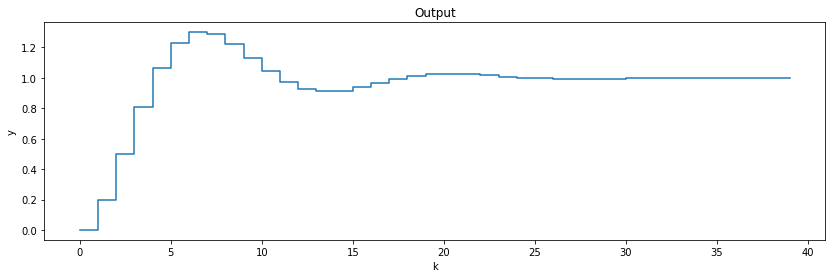

In [6]:
tvec = np.arange(40)
(t1, y1) = control.step_response(Hc,tvec)
plt.figure(figsize=(14,4))
plt.step(t1, y1[0])
plt.xlabel('k')
plt.ylabel('y')
plt.title('Output')

Text(0.5,1,'Control signal')

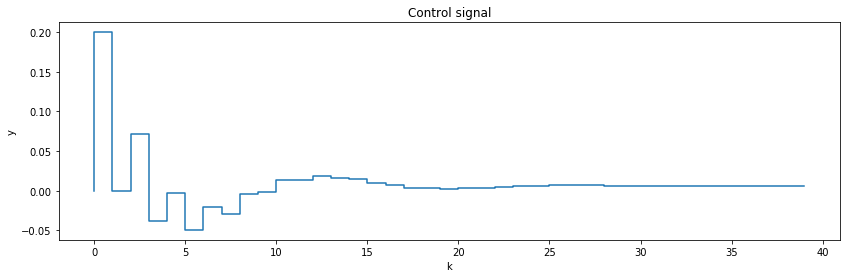

In [7]:
(t1, y1) = control.step_response(Hcu,tvec)
plt.figure(figsize=(14,4))
plt.step(t1, y1[0])
plt.xlabel('k')
plt.ylabel('y')
plt.title('Control signal')

## Solve (b) on your own

## Solve (c) on your own